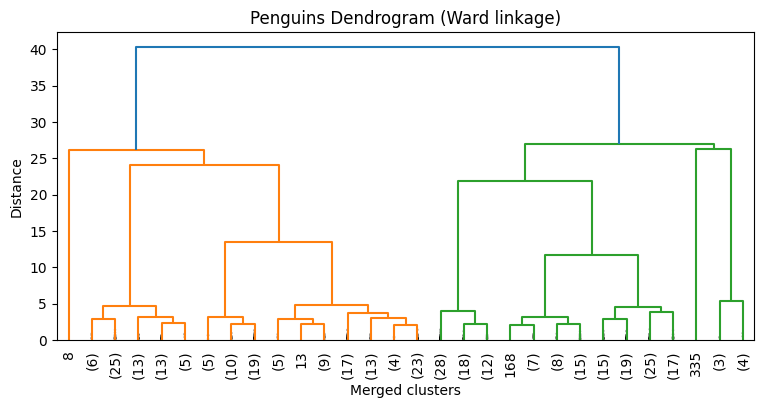

Silhouette (SciPy fcluster, k=3):   0.456
Silhouette (sklearn Agglo, k=3):    0.456


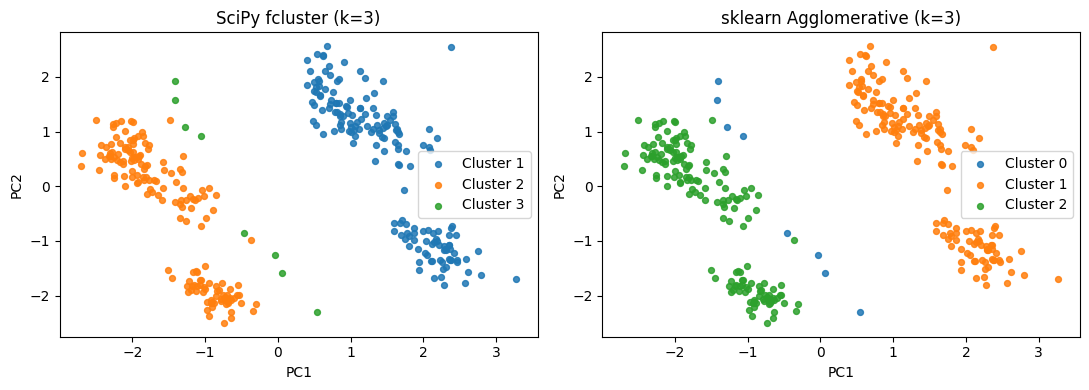

[Linkage=single  ] Silhouette=0.829
[Linkage=complete] Silhouette=0.829
[Linkage=average ] Silhouette=0.829
[Linkage=ward    ] Silhouette=0.456
Silhouette (K-Means, k=3):          0.455

Tóm tắt theo cụm (Agglomerative):
        culmen_length_mm                             culmen_depth_mm  \
                    mean       std   min   max count            mean   
cluster                                                                
0              41.212500  4.945543  34.1  47.3     8       16.200000   
1              45.831953  5.359109  34.6  59.6   169       17.904734   
2              42.096970  4.903476  32.1  58.0   165       16.425455   

                                    flipper_length_mm                     \
              std   min   max count              mean         std    min   
cluster                                                                    
0        1.919077  13.8  18.9     8        200.125000   17.249741  179.0   
1        1.866267  14.1  21.5   169       

In [1]:
# ============================
# 3.2. Phân cụm đa cấp - Penguins
# ============================
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans  # (tuỳ chọn) so sánh
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# 1) Import & kiểm tra dữ liệu
CSV_PATH = "/kaggle/input/clustering-penguins-species/penguins.csv"   # <-- ĐỔI PATH CHO PHÙ HỢP
df = pd.read_csv(CSV_PATH)

# Đưa cột về dạng nhất quán
df.columns = [c.strip().lower() for c in df.columns]

# Tên cột mong đợi
NUM_COLS = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']
CAT_COLS = ['sex']

# Làm sạch đơn giản: loại bỏ thiếu ở cột số; sex -> one-hot
df['sex'] = df['sex'].astype('string').str.strip().str.title()   # 'Male'/'Female'/nan
df['sex'] = df['sex'].fillna('Unknown')
df = pd.get_dummies(df, columns=CAT_COLS, drop_first=False)

# Loại bỏ thiếu ở cột số (hoặc bạn có thể dùng imputer)
df = df.dropna(subset=NUM_COLS).reset_index(drop=True)

# Ma trận đặc trưng X (số + one-hot sex_*)
FEATS = NUM_COLS + [c for c in df.columns if c.startswith('sex_')]
X = df[FEATS].copy()

# 2) Chuẩn hoá dữ liệu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3) SciPy: linkage + dendrogram + fcluster
# Lưu ý: Ward yêu cầu Euclidean và dữ liệu numeric (đã đảm bảo ở trên)
Z = linkage(X_scaled, method='ward', metric='euclidean')

plt.figure(figsize=(9, 4))
dendrogram(Z, truncate_mode='lastp', p=30, leaf_rotation=90., show_contracted=True)
plt.title('Penguins Dendrogram (Ward linkage)')
plt.xlabel('Merged clusters'); plt.ylabel('Distance')
# ví dụ vẽ ngưỡng cắt (chỉnh tùy dữ liệu)
# plt.axhline(y=20, c='r', ls='--')
plt.show()

# Cắt theo số cụm (ví dụ 3) bằng criterion='maxclust'
k = 3
labels_scipy = fcluster(Z, t=k, criterion='maxclust')

# 4) AgglomerativeClustering (scikit-learn)
# Thử average/complete/single/ward (ward tốt khi cụm “gần cầu”)
ac = AgglomerativeClustering(n_clusters=k, linkage='ward')  # 'average'/'complete'/'single'/'ward'
labels_sklearn = ac.fit_predict(X_scaled)

# 5) Đánh giá Silhouette (tuỳ chọn)
sil_scipy = silhouette_score(X_scaled, labels_scipy)
sil_sklearn = silhouette_score(X_scaled, labels_sklearn)
print(f"Silhouette (SciPy fcluster, k={k}):   {sil_scipy:.3f}")
print(f"Silhouette (sklearn Agglo, k={k}):    {sil_sklearn:.3f}")

# 6) Trực quan 2D bằng PCA
pca = PCA(n_components=2, random_state=42)
X2 = pca.fit_transform(X_scaled)

fig, ax = plt.subplots(1, 2, figsize=(11,4))
pal = sns.color_palette('tab10', n_colors=k)

for c in range(1, k+1):  # fcluster trả nhãn 1..k
    idx = (labels_scipy == c)
    ax[0].scatter(X2[idx,0], X2[idx,1], s=18, alpha=0.85, color=pal[c-1], label=f'Cluster {c}')
ax[0].set_title(f'SciPy fcluster (k={k})'); ax[0].set_xlabel('PC1'); ax[0].set_ylabel('PC2'); ax[0].legend()

for c in range(k):       # Agglomerative trả nhãn 0..k-1
    idx = (labels_sklearn == c)
    ax[1].scatter(X2[idx,0], X2[idx,1], s=18, alpha=0.85, color=pal[c], label=f'Cluster {c}')
ax[1].set_title(f'sklearn Agglomerative (k={k})'); ax[1].set_xlabel('PC1'); ax[1].set_ylabel('PC2'); ax[1].legend()

plt.tight_layout(); plt.show()

# 7) Thử nhiều linkage (giống phần 3.2.2.5 trong hướng dẫn)
methods = ['single', 'complete', 'average', 'ward']  # 'centroid' không có trong sklearn AC
for method in methods:
    Zm = linkage(X_scaled, method=method, metric='euclidean')
    # cắt theo số cụm k cho công bằng
    cl = fcluster(Zm, t=k, criterion='maxclust')
    sil = silhouette_score(X_scaled, cl)
    print(f"[Linkage={method:<8}] Silhouette={sil:.3f}")

# 8) (Tuỳ chọn) So sánh với K-Means (k giống nhau)
km = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
km_labels = km.fit_predict(X_scaled)
sil_km = silhouette_score(X_scaled, km_labels)
print(f"Silhouette (K-Means, k={k}):          {sil_km:.3f}")

# 9) Thống kê mô tả theo cụm (Agglomerative)
grp = pd.concat([df[NUM_COLS], pd.Series(labels_sklearn, name='cluster')], axis=1)
desc = grp.groupby('cluster')[NUM_COLS].agg(['mean','std','min','max','count'])
print("\nTóm tắt theo cụm (Agglomerative):")
print(desc)
